# Homework 1 (Due: February 27, 2023)

## 1. Fitting a model to data

1. Prepare an artificial data set composed of $t$ = \[0.0, 0.1, 0.2,..., 200\] and $y = 0.8e^{-c_1 t}+0.2 e^{-c_2 t}$ where $c_1$ = 0.1 and $c_2$ = 0.01. Then, use [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to find the best fit of our "model" of the functional form $y = A \exp(-a t)$ where $A$ and $a$ are constant parameters.
2. Add gaussian noise ([`numpy.random.randn`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)) to the $y$ data and see how the model fitting is affected depending on the amplitude of the noise. Also, compare the results with a model with two exponential terms, $y = A_1 \exp(-a_1 t) + A_2 \exp(-a_2 t)$. How would you determine which model is better given the goodness of fit and number of parameters?
3. Load the data file `ipsc_acc_17711000.dat` (Use [`numpy.loadtxt`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html)). Note that the first and second column are time in millisecond and a time series derived from experimental data, respectively) and try to fit the sum-of-exponentials models to this data. Choose your best model/fit and describe how you validate the result.

In [10]:
import numpy as np
import scipy.optimize as op
import plotly.express as px
import plotly.graph_objects as go


# 1.
t = np.arange(0, 200, 0.1)
c1 = 0.1
c2 = 0.01
y = 0.8 * np.exp(- c1 * t) + 0.2 * np.exp(- c2 * t)

def model(t, A, a):
    return A * np.exp(-a*t)

params, _ = op.curve_fit(model, t, y, [1]*2)
res = model(t, *params)


# 2.
y_noise = y + np.random.normal(0, 0.1, len(y))

def model2(t, A1, a1, A2, a2):
    return A1 * np.exp(- a1 * t) + A2 * np.exp(- a2 * t)

params_noise, _ = op.curve_fit(model, t, y_noise, [1]*2)
res_noise = model(t, *params_noise)

params2, _ = op.curve_fit(model2, t, y, [0.5]*4)
res2 = model2(t, *params2)
params2_noise, _ = op.curve_fit(model2, t, y_noise, [0.5]*4)
res2_noise = model2(t, *params2_noise)



fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y,
                    mode='markers+lines',
                    name='artificial y'))
fig.add_trace(go.Scatter(x=t, y=y_noise,
                    mode='markers+lines',
                    name='artificial y with noise'))
fig.add_trace(go.Scatter(x=t, y=res, 
                    mode='lines',
                    name='model 1 fitted to y'))
fig.add_trace(go.Scatter(x=t, y=res_noise,
                    mode='lines',
                    name='model 1 fitted to y with noise'))
fig.add_trace(go.Scatter(x=t, y=res2,
                    mode='lines',
                    name='model 2 fitted to y'))
fig.add_trace(go.Scatter(x=t, y=res2_noise,
                    mode='lines',
                    name='model 2 fitted to y with noise'))

fig.show()
print(params2, params2_noise)

# from plotly.subplots import make_subplots
# stds = [dev/np.var(dev) for dev in deviations]
# variances = [np.var(std) for std in stds]
# aics = [len(y) * np.log() + 2*2 for dev in deviations]
# print(aics)

# fig_bar = make_subplots(specs=[[{"secondary_y": True}]])

# # fig_bar.add_trace(go.Bar(name='variance', x=['model 1 fitted to y', 'model 1 fitted to y with noise', 'model 2 fitted to y', 'model 2 fitted to y with noise'], y=variances), secondary_y=False)
# fig_bar.add_trace(go.Bar(name='AIC', x=['model 1 fitted to y', 'model 1 fitted to y with noise', 'model 2 fitted to y', 'model 2 fitted to y with noise'], y=aics), secondary_y=True)
# fig_bar.show()

/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/2176644665.py:24: RuntimeWarning:

overflow encountered in exp

/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/2176644665.py:24: RuntimeWarning:

overflow encountered in multiply



[0.2  0.01 0.8  0.1 ] [0.18150354 0.00924178 0.82499604 0.09945051]


In [11]:
data = np.loadtxt("ipsc_acc_17711000.dat")
t_data = data[:, 0]
y_data = data[:, 1]

y_data_norm = y_data[len(y_data)//2:]

def model_n(t, *params):
    assert len(params) % 2 == 0, "Number of parameters must be even"
    n = len(params) // 2
    result = 0
    for i in range(n):
        A_i, a_i = params[2*i], params[2*i+1]
        result += A_i * np.exp(- a_i * t)
    return result

n_expos_lst = [1, 2, 3, 4]
res_data_lst = []
for n_expos in n_expos_lst:
    params_data, _ = op.curve_fit(model_n, t_data, y_data, [1]*2*n_expos)
    res_data_lst.append(model_n(t, *params_data))



fig = go.Figure()
fig.add_trace(go.Scatter(x=t_data, y=y_data,
                    mode='markers+lines',
                    name='data'))
for i in range(len(n_expos_lst)):
    fig.add_trace(go.Scatter(x=t_data, y=res_data_lst[i],
                        mode='lines',
                        name=f'{i+1} exponentials fitted to data'))

fig.show()


/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/47218837.py:13: RuntimeWarning:

overflow encountered in exp

/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/47218837.py:13: RuntimeWarning:

overflow encountered in multiply

/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/47218837.py:13: RuntimeWarning:

invalid value encountered in add

/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/47218837.py:13: RuntimeWarning:

overflow encountered in add



## 2. Inspecting membrane properties via current clamp

Following an example in our NEURON Tutorial 1, create an axon simulation
with the following specifications:

- Diameter (`diam`) = 1 um and length (`L`) = 1000 um,
- Capacitance per area (`cm`) = 1 uF/cm2,
- Passive mechanism (`pas`) with the conductance per area = $1\times10^{-4}$ S/cm2. (**Hint**: the conductance variable for this mechanism is `axon.g_pas`)
- A current clamp electrode (`ic`) near one end (`x`≈0) that injects 50 pA for a sufficiently long time (>200 ms).

1. What are the theoretical membrane time constant (τ) and space constant (λ)?
2. Run the simulation and measure the membrane time constant from the simulated data. How does the measured time constant compare with the theoretical value?
3. What is the electrotonic length of this axon?
4. **(Fig. 2.4)** By changing the length (`L`), plot the voltage attenuation curve in Fig. 2.4 in the textbook. Note that the unconnected cylinder ends in NEURON are sealed, and you will reproduce the "Sealed end" case. Discuss implications in membrane potential dynamics in short versus long dendrites.


In [25]:
from neuron import h, gui
axon = h.Section(name="axon")
axon.L = 1000 #um long
axon.diam = 1 # 1 um diameter 
axon.insert("pas")
axon.g_pas = 1e-4
axon.nseg = 1001

# print(axon.psection())
print('axon status:', h.psection())

h.tstop = 1e5
h.init()

ic = h.IClamp(axon(1e-5))
ic.delay = 0
ic.dur = 3e2
ic.amp = .05

__nrnsec_0x7faa481780c0 { nseg=101  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=1}
	insert pas { g_pas=0.0001 e_pas=-70}
}
axon status: 1.0


The theoretical time constant is 
$$
\tau_m = r_m c_m = R_m C_m = \frac{C_m}{G_m} = \frac{1 \times 10^{-6}}{1 \times 10^{-4}} = 10^{-2} [s]
$$
and the theoretical space constant is
$$
\lambda = \left( \frac{r_m}{r_a} \right) ^{1/2} = \left( \frac{R_m}{R_i} \cdot \frac{d}{4} \right)^{1/2}
= \left( \frac{1}{G_m} \cdot \frac{1}{R_i} \cdot \frac{d}{4} \right)^{1/2}
= \left( \frac{1}{ 10^{-4}} \cdot \frac{1}{1} \right)

In [26]:
import matplotlib.pyplot as plt

# Here we define a function for setting recordings and running
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    
    trec = h.Vector() # Record time
    vrec = h.Vector() # Record voltage
    
    trec.record(h._ref_t, dt)
    vrec.record(axon(1e-5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return trec.c(), vrec.c() # Should return a copy of the vector

t, vrec = run()

# define model
def model_n(t, *params):
    assert len(params) % 2 == 0, "Number of parameters must be even"
    n = len(params) // 2
    result = 0
    for i in range(n):
        A_i, a_i = params[2*i], params[2*i+1]
        result += A_i * np.exp(- a_i * t)
    return result

# fit the model with different number of components
n_expos_lst = [1, 2, 3]
res_data_lst = []
for n_expos in n_expos_lst:
    params_data, _ = op.curve_fit(model_n, t, vrec, [1]*2*n_expos)
    res_data_lst.append(model_n(t, *params_data))
    print([ f'tau_{i%2}: {1/params_data[i%2+1]}' for i in range(n_expos)])


fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=vrec,
                    mode='markers+lines',
                    name='simulation'))
for i in range(len(n_expos_lst)):
    fig.add_trace(go.Scatter(x=t, y=res_data_lst[i],
                        mode='lines',
                        name=f'{i+1} exponentials fitted to simulation'))

fig.show()



['tau_0: 4571.004479723374']
['tau_0: 0.0006761489744421012', 'tau_1: -0.020424610418012894']
['tau_0: 0.7964072759648001', 'tau_1: -0.08902479210979401', 'tau_0: 0.7964072759648001']


/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/144816279.py:29: RuntimeWarning:

overflow encountered in exp

/var/folders/gr/2yqx26fd1mzcfbrhlr32l5qh0000gp/T/ipykernel_14051/144816279.py:29: RuntimeWarning:

overflow encountered in multiply

/Users/stashtomonaga/opt/miniconda3/envs/compneuro/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning:

Covariance of the parameters could not be estimated



In [38]:
axon = h.Section(name="axon")
axon.L = 1000 #um long
axon.diam = 1 # 1 um diameter 
axon.insert("pas")
axon.g_pas = 1e-4
axon.nseg = 1001

# print(axon.psection())
print('axon status:', h.psection())

h.tstop = 1e5
h.init()

ic = h.IClamp(axon(1e-5))
ic.delay = 0
ic.dur = 3e2
ic.amp = .05

def run_attenuation(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""    
    vectors = []
    for seg in axon:
        vec = h.Vector()
        vec.record(seg._ref_v)
        vectors.append(vec)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()

    voltage_traces = [vec.to_python() for vec in vectors]
    distances = [seg.x for seg in axon]
    # Obtain steady state at each segment, normalized by the initial segment
    attenuations = [voltage_traces[i][-1] / voltage_traces[0][-1] for i in range(len(voltage_traces))]

    return distances, attenuations

x, v = run_attenuation()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=v,
                    mode='lines',
                    name='v'))

fig.show()


__nrnsec_0x7faa481780c0 { nseg=101  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=1}
	insert pas { g_pas=0.0001 e_pas=-70}
}
axon status: 1.0


__nrnsec_0x7faa48178060 { nseg=101  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=1}
}
1.0


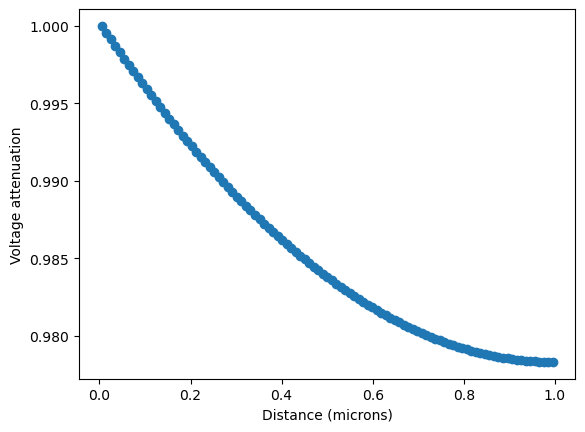

In [17]:
from neuron import h
import matplotlib.pyplot as plt

# Create an axon section
axon = h.Section()
axon.L = 500 # 1000 um long
axon.diam = 1 # 1 um diameter 
# axon.insert("pas")
# axon.g_pas = 1e-4
axon.nseg = 101  # number of segments
print(h.psection())



# Insert an extracellular electrode at the center of the axon
ic = h.IClamp(axon(1e-5))
ic.delay = 0
ic.dur = 3e2
ic.amp = .05

# Record the membrane potential at each segment of the axon
vectors = []
for seg in axon:
    vec = h.Vector()
    vec.record(seg._ref_v)
    vectors.append(vec)

# Run the simulation
h.tstop = 100  # milliseconds
h.run()

# Extract the voltage traces and calculate the voltage attenuation
voltage_traces = [vec.to_python() for vec in vectors]
distances = [seg.x for seg in axon]
attenuations = [voltage_traces[i][-1] / voltage_traces[0][-1] for i in range(len(voltage_traces))]

# Plot the voltage attenuation curve
plt.scatter(distances, attenuations)
plt.xlabel('Distance (microns)')
plt.ylabel('Voltage attenuation')
plt.show()


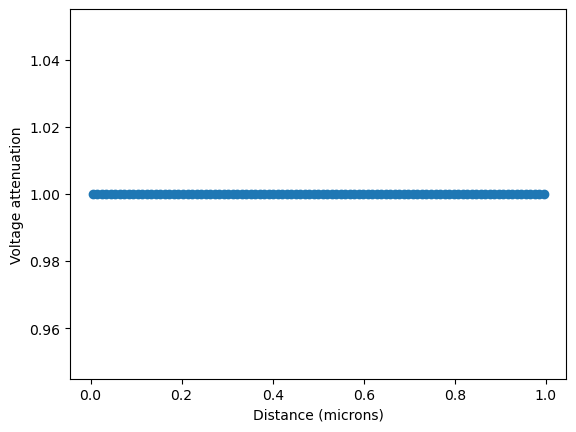

In [18]:
from neuron import h
import matplotlib.pyplot as plt

# Create an axon section with passive properties
axon = h.Section()
axon.L = 1000  # microns
axon.diam = 1  # microns
axon.nseg = 101  # number of segments
axon.insert('pas')
axon.g_pas = 1e-4

# Insert a current clamp electrode at one end of the axon
iclamp = h.IClamp(1e-5)
iclamp.delay = 0.1  # milliseconds
iclamp.dur = 500  # milliseconds
iclamp.amp = .05  # picoamps

# Record the membrane potential at each segment of the axon
vectors = []
for seg in axon:
    vec = h.Vector()
    vec.record(seg._ref_v)
    vectors.append(vec)

# Run the simulation
h.tstop = 1000  # milliseconds
h.run()

# Extract the voltage traces and calculate the voltage attenuation
voltage_traces = [vec.to_python() for vec in vectors]
distances = [seg.x for seg in axon]
attenuations = [voltage_traces[i][-1] / voltage_traces[0][-1] for i in range(len(voltage_traces))]

# Plot the voltage attenuation curve
plt.scatter(distances, attenuations)
plt.xlabel('Distance (microns)')
plt.ylabel('Voltage attenuation')
plt.show()


## 3. Fig. 2.5 and 2.8B

Using the simulation in Quesion 2, plot the sealed end case of Fig. 2.5 in the textbook by following the steps below. 

1. **(I-V curve)** Try a few different values for the injected current from -50 pA to 50 pA, record the steady state membrane voltages, and plot the current vs membrane voltage graph. What is the input resistance?
2. **(Fig. 2.5)** Draw the cable length curve versus input resistance curve as Fig. 2.5 in the textbook. Please make sure that the cable has the sufficiently large `nseg` to get a quasi-smooth curve. Again, you should be able to get only one curves since cables in NEURON have sealed-ends.
3. **(Fig. 2.8B)** Set the length sufficiently long and plot how the voltage changes in time during current injection at different locations as in Fig. 2.8B.

In [37]:
from neuron import h, gui
from scipy.stats import linregress as lr

axon = h.Section(name="axon")
axon.L = 1000 #um long
axon.diam = 1 # 1 um diameter 
axon.insert("pas")
axon.g_pas = 1e-4
axon.nseg = 1001

# print(axon.psection())
print('axon status:', h.psection())

h.tstop = 1e5
h.init()

ic = h.IClamp(axon(1e-5))
ic.delay = 0
ic.dur = 3e2

def run(amp, tstop=250):

    ic.amp = amp  # picoamps

    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    
    trec = h.Vector() # Record time
    vrec = h.Vector() # Record voltage
    
    trec.record(h._ref_t, dt)
    vrec.record(axon(1e-5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return trec.c(), vrec.c() # Should return a copy of the vector

amplitudes = np.linspace(-0.05, 0.05, 10)
vs = []
for amp in amplitudes:
    t, vrec = run(amp, 500)
    vs.append(vrec[-1])

slope, intercept, _, _, _ = lr(amplitudes, vs)


fig = go.Figure()
fig.add_trace(go.Scatter(x=amplitudes, y=vs,
                    mode='markers',
                    name='simulated data'))
fig.add_trace(go.Scatter(x=amplitudes, y=[slope * amp + intercept for amp in amplitudes],
                    mode='lines',
                    name='linear fit'))
fig.show()

print(f'input resistance is {slope}')

__nrnsec_0x7faa481780c0 { nseg=101  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=1}
	insert pas { g_pas=0.0001 e_pas=-70}
}
axon status: 1.0


input resistance is 6.794200751094401e-07


In [40]:
axon = h.Section(name="axon")
axon.L = 10000 #um long
axon.diam = 1 # 1 um diameter 
axon.insert("pas")
axon.g_pas = 1e-4
axon.nseg = 1001

# print(axon.psection())
print('axon status:', h.psection())

ic = h.IClamp(axon(1e-5))
ic.delay = 0
ic.dur = 3e2
ic.amp = .05


def run_diff_distance(lamb=1e-3, n=3, tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    trec = h.Vector() # Record time
    vrecs = []
    for i in range(n):
        vrecs.append(h.Vector()) # Record voltage

    trec.record(h._ref_t, dt)
    for i in range(n):
        vrecs[i].record(axon(1e-5 + lamb*i)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    res_vs = [vrec.c() for vrec in vrecs]
    return trec.c(), res_vs # Should return a copy of the vector

n = 3
t, vrecs = run(n=3)


fig = go.Figure()
for i in range(n):
    fig.add_trace(go.Scatter(x=t, y=vrecs[i]
                        mode='lines',
                        name=f'{i+1} exponentials fitted to simulation'))

fig.show()


__nrnsec_0x7faa481780c0 { nseg=101  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=1}
	insert pas { g_pas=0.0001 e_pas=-70}
}
axon status: 1.0
